In [11]:
import findspark
findspark.init()

In [12]:
from pyspark.sql import SparkSession, DataFrame

# Connect to Spark cluster when running in Docker (master is set via env MASTER=spark://master:7077)
spark = SparkSession.builder \
    .appName("pyspark-assesment") \
    .getOrCreate()

### Read data

In [13]:
df = spark.read.csv("/dataset/nyc-jobs.csv", header=True)
df.printSchema()

root
 |-- Job ID: string (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Posting Type: string (nullable = true)
 |-- # Of Positions: string (nullable = true)
 |-- Business Title: string (nullable = true)
 |-- Civil Service Title: string (nullable = true)
 |-- Title Code No: string (nullable = true)
 |-- Level: string (nullable = true)
 |-- Job Category: string (nullable = true)
 |-- Full-Time/Part-Time indicator: string (nullable = true)
 |-- Salary Range From: string (nullable = true)
 |-- Salary Range To: string (nullable = true)
 |-- Salary Frequency: string (nullable = true)
 |-- Work Location: string (nullable = true)
 |-- Division/Work Unit: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Minimum Qual Requirements: string (nullable = true)
 |-- Preferred Skills: string (nullable = true)
 |-- Additional Information: string (nullable = true)
 |-- To Apply: string (nullable = true)
 |-- Hours/Shift: string (nullable = true)
 |-- Work Locatio

### Sample function

In [14]:
def get_salary_frequency(df: DataFrame) -> list:
    row_list = df.select('Salary Frequency').distinct().collect()
    return [row['Salary Frequency'] for row in row_list]

### Example of test function

In [15]:
mock_data = [('A', 'Annual'), ('B', 'Daily')]
expected_result = ['Annual', 'Daily']

In [16]:
def test_get_salary_frequency(mock_data: list, 
                              expected_result: list,
                              schema: list = ['id', 'Salary Frequency']):  
    mock_df = spark.createDataFrame(data=mock_data, schema=schema)
    assert get_salary_frequency(mock_df) == expected_result

# Run the test
test_get_salary_frequency(mock_data, expected_result)

---
# Part 1: Data Exploration

## 1.1 Detailed analysis of source data (profiling)

We analyze column types (numeric vs character), nulls, and categorical columns.

In [23]:
# Visualization and PySpark SQL helpers
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, IntegerType, DateType

# --- Data profiling: row count, nulls, column types ---
print("=== Row count ===")
print(df.count())
print("\n=== Schema (all read as string from CSV) ===")
df.printSchema()
print("\n=== Null counts per column ===")
df.select([F.count(F.when(F.col(c).isNull() | (F.trim(F.col(c)) == ""), 1)).alias(c) for c in df.columns]).show(vertical=True)
print("\n=== Sample of key columns ===")
df.select("Job ID", "Agency", "Job Category", "Salary Range From", "Salary Range To", "Salary Frequency", "Posting Date").show(5, truncate=False)

=== Row count ===
2946

=== Schema (all read as string from CSV) ===
root
 |-- Job ID: string (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Posting Type: string (nullable = true)
 |-- # Of Positions: string (nullable = true)
 |-- Business Title: string (nullable = true)
 |-- Civil Service Title: string (nullable = true)
 |-- Title Code No: string (nullable = true)
 |-- Level: string (nullable = true)
 |-- Job Category: string (nullable = true)
 |-- Full-Time/Part-Time indicator: string (nullable = true)
 |-- Salary Range From: string (nullable = true)
 |-- Salary Range To: string (nullable = true)
 |-- Salary Frequency: string (nullable = true)
 |-- Work Location: string (nullable = true)
 |-- Division/Work Unit: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Minimum Qual Requirements: string (nullable = true)
 |-- Preferred Skills: string (nullable = true)
 |-- Additional Information: string (nullable = true)
 |-- To Apply: string (nullable

In [24]:
# Categorical columns: distinct value counts (for low-cardinality identification)
categorical_candidates = ["Posting Type", "Salary Frequency", "Full-Time/Part-Time indicator", "Job Category", "Level"]
print("=== Categorical column distinct counts ===")
for col_name in categorical_candidates:
    cnt = df.select(col_name).distinct().count()
    print(f"  {col_name}: {cnt} distinct")
# Numerical (stored as string): Job ID, # Of Positions, Salary Range From/To, Title Code No, Level, dates
print("\n=== Columns that are numerical in meaning (stored as string in CSV) ===")
print("  Job ID, # Of Positions, Salary Range From, Salary Range To, Title Code No, Level, Posting Date, etc.")

=== Categorical column distinct counts ===
  Posting Type: 2 distinct
  Salary Frequency: 3 distinct
  Full-Time/Part-Time indicator: 3 distinct
  Job Category: 131 distinct
  Level: 14 distinct

=== Columns that are numerical in meaning (stored as string in CSV) ===
  Job ID, # Of Positions, Salary Range From, Salary Range To, Title Code No, Level, Posting Date, etc.


## 1.2 KPIs

We need to cast salary and date columns for analysis. Creating a helper DataFrame with typed numeric/date columns.

In [39]:
# Helper: build typed DF for KPIs (cast salary and date; normalize to annual; filter valid rows where needed)
def build_analytics_df(raw_df):
    """Cast salary and date columns for KPI analysis. Normalize salary to annual for comparison."""
    d = raw_df \
        .withColumn("salary_from", F.regexp_replace(F.col("Salary Range From"), "[,$]", "").cast(DoubleType())) \
        .withColumn("salary_to", F.regexp_replace(F.col("Salary Range To"), "[,$]", "").cast(DoubleType())) \
        .withColumn("salary_freq", F.col("Salary Frequency")) \
        .withColumn("posting_date", F.to_date(F.col("Posting Date"), "yyyy-MM-dd")) \
        .withColumn("num_positions", F.regexp_replace(F.col("# Of Positions"), "[^0-9]", "").cast(IntegerType()))
    # Approximate annual salary: Hourly*2080, Daily*260, else use as-is
    d = d.withColumn(
        "salary_annual_from",
        F.when(F.lower(F.col("salary_freq")).contains("hour"), F.col("salary_from") * 2080)
         .when(F.lower(F.col("salary_freq")).contains("day"), F.col("salary_from") * 260)
         .otherwise(F.col("salary_from"))
    ).withColumn(
        "salary_annual_to",
        F.when(F.lower(F.col("salary_freq")).contains("hour"), F.col("salary_to") * 2080)
         .when(F.lower(F.col("salary_freq")).contains("day"), F.col("salary_to") * 260)
         .otherwise(F.col("salary_to"))
    ).withColumn("salary_mid_annual", (F.col("salary_annual_from") + F.col("salary_annual_to")) / 2)
    return d

# Build analytics DF (includes salary_mid_annual)
df_analytics = build_analytics_df(df)
# For salary-based KPIs, use rows with valid salary midpoint
df_sal = df_analytics.filter(F.col("salary_mid_annual").isNotNull() & (F.col("salary_mid_annual") > 0))
print("Rows with valid salary for salary-based KPIs:", df_sal.count())

Rows with valid salary for salary-based KPIs: 2946


### KPI 1: Number of job postings per category (Top 10)

+-----------------------------------------+-----+
|Job Category                             |count|
+-----------------------------------------+-----+
|Engineering, Architecture, & Planning    |504  |
|Technology, Data & Innovation            |313  |
|Legal Affairs                            |226  |
|Public Safety, Inspections, & Enforcement|182  |
|Building Operations & Maintenance        |181  |
|Finance, Accounting, & Procurement       |169  |
|Administration & Human Resources         |134  |
|Constituent Services & Community Programs|129  |
|Health                                   |125  |
|Policy, Research & Analysis              |124  |
+-----------------------------------------+-----+



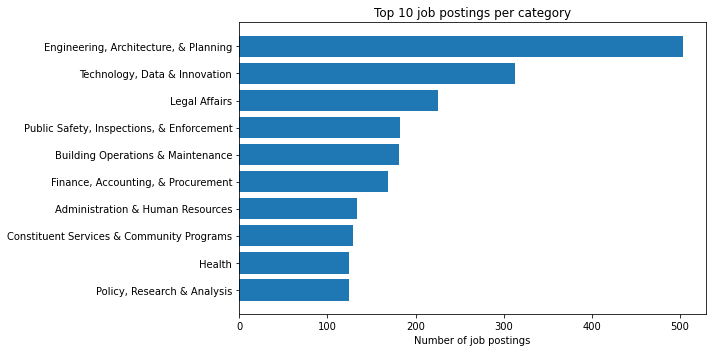

In [26]:
# Count postings per category; fill null Job Category as "Unspecified"
kpi1 = df.withColumn("Job Category", F.when(F.col("Job Category").isNull() | (F.trim(F.col("Job Category")) == ""), F.lit("Unspecified")).otherwise(F.col("Job Category"))) \
    .groupBy("Job Category").count().orderBy(F.desc("count")).limit(10)
kpi1.show(10, truncate=False)
# Collect for plotting
kpi1_pd = kpi1.toPandas()
plt.figure(figsize=(10, 5))
plt.barh(kpi1_pd["Job Category"].astype(str)[::-1], kpi1_pd["count"][::-1])
plt.xlabel("Number of job postings")
plt.title("Top 10 job postings per category")
plt.tight_layout()
plt.show()

### KPI 2: Salary distribution per job category

+-----------------------------------------+-----------------+------------------+----------+-----+
|Job Category                             |avg_salary       |min_salary        |max_salary|count|
+-----------------------------------------+-----------------+------------------+----------+-----+
|Technology, Data & Innovation            |90939.57863258786|32957.600000000006|169011.0  |313  |
|Engineering, Architecture, & Planning    |85129.01674603175|363.92            |151795.0  |504  |
|Legal Affairs                            |84739.9537876106 |37398.0           |191913.0  |226  |
|Health                                   |77541.46467199999|33166.0           |170133.84 |125  |
|Finance, Accounting, & Procurement       |74945.58118343195|21539.5           |167500.0  |169  |
|Policy, Research & Analysis              |67388.16354838709|175.1             |162051.0  |124  |
|Constituent Services & Community Programs|67209.49485271318|31371.5           |135000.0  |129  |
|Public Safety, Insp

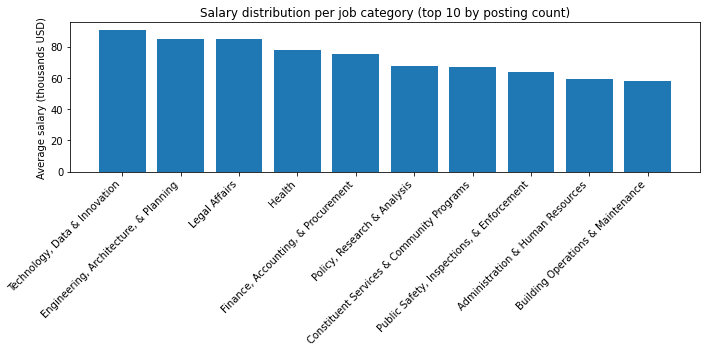

In [27]:
# Salary distribution per job category (mean salary mid, top 10 categories by count)
df_sal_cat = df_sal.withColumn("Job Category", F.when(F.col("Job Category").isNull() | (F.trim(F.col("Job Category")) == ""), F.lit("Unspecified")).otherwise(F.col("Job Category")))
kpi2_counts = df_sal_cat.groupBy("Job Category").count()
top_cats = [r["Job Category"] for r in kpi2_counts.orderBy(F.desc("count")).limit(10).collect()]
kpi2 = df_sal_cat.filter(F.col("Job Category").isin(top_cats)) \
    .groupBy("Job Category").agg(
        F.avg("salary_mid_annual").alias("avg_salary"),
        F.min("salary_mid_annual").alias("min_salary"),
        F.max("salary_mid_annual").alias("max_salary"),
        F.count("*").alias("count")
    ).orderBy(F.desc("avg_salary"))
kpi2.show(10, truncate=False)
kpi2_pd = kpi2.toPandas()
plt.figure(figsize=(10, 5))
x = range(len(kpi2_pd))
plt.bar(x, kpi2_pd["avg_salary"] / 1000)
plt.xticks(x, kpi2_pd["Job Category"], rotation=45, ha="right")
plt.ylabel("Average salary (thousands USD)")
plt.title("Salary distribution per job category (top 10 by posting count)")
plt.tight_layout()
plt.show()

### KPI 3: Correlation between higher degree and salary

We derive a "highest degree" level from the Minimum Qual Requirements text (e.g. baccalaureate, master's, PhD) and compare average salary.

+------------+-----------------+-----+
|degree_level|       avg_salary|count|
+------------+-----------------+-----+
|      Master|89117.00710833333|  480|
|         PhD|85890.03086419753|   81|
|    Bachelor|76746.33761580382| 1468|
| Unspecified|76523.92555993033|  574|
| High school|55340.21928888889|  315|
|   Associate|50230.88071428572|   28|
+------------+-----------------+-----+



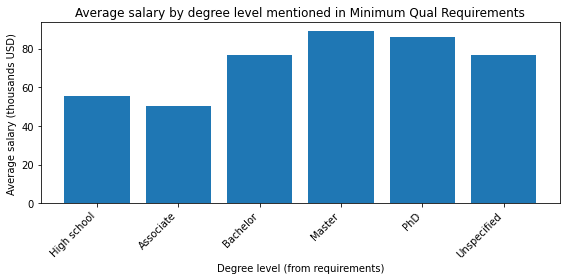

Conclusion: postings requiring higher degrees tend to show higher average salary in this dataset.


In [28]:
# Derive degree level from Minimum Qual Requirements (text)
# Order: PhD > Master > Baccalaureate > Associate/60 credits > High school
df_degree = df_sal.withColumn("req", F.lower(F.coalesce(F.col("Minimum Qual Requirements"), F.lit(""))))
df_degree = df_degree.withColumn(
    "degree_level",
    F.when(F.col("req").rlike(r"ph\.?d|doctorate"), F.lit("PhD"))
     .when(F.col("req").rlike(r"master\'?s|m\.?b\.?a|graduate degree"), F.lit("Master"))
     .when(F.col("req").rlike(r"baccalaureate|bachelor|four.year college"), F.lit("Bachelor"))
     .when(F.col("req").rlike(r"associate|60 semester credits"), F.lit("Associate"))
     .when(F.col("req").rlike(r"high school|ged|equivalent"), F.lit("High school"))
     .otherwise(F.lit("Unspecified"))
)
kpi3 = df_degree.groupBy("degree_level").agg(
    F.avg("salary_mid_annual").alias("avg_salary"),
    F.count("*").alias("count")
).orderBy(F.desc("avg_salary"))
kpi3.show()
# Correlation view: higher degree tiers vs salary
order_degree = ["High school", "Associate", "Bachelor", "Master", "PhD", "Unspecified"]
kpi3_pd = kpi3.toPandas()
kpi3_pd["degree_level"] = kpi3_pd["degree_level"].astype("category").cat.set_categories(order_degree)
kpi3_pd = kpi3_pd.sort_values("degree_level")
plt.figure(figsize=(8, 4))
plt.bar(kpi3_pd["degree_level"].astype(str), kpi3_pd["avg_salary"] / 1000)
plt.xlabel("Degree level (from requirements)")
plt.ylabel("Average salary (thousands USD)")
plt.title("Average salary by degree level mentioned in Minimum Qual Requirements")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
print("Conclusion: postings requiring higher degrees tend to show higher average salary in this dataset.")

### KPI 4: Job posting with highest salary per agency

In [29]:
# Per agency: pick one row with max salary (salary_mid_annual); show job title and salary
from pyspark.sql.window import Window
w = Window.partitionBy("Agency").orderBy(F.desc("salary_mid_annual"))
kpi4 = df_sal.withColumn("rn", F.row_number().over(w)).filter(F.col("rn") == 1) \
    .select("Agency", "Business Title", "salary_mid_annual", "salary_annual_from", "salary_annual_to") \
    .orderBy(F.desc("salary_mid_annual")).limit(15)
kpi4.show(15, truncate=40)

+------------------------------+----------------------------------------+------------------+------------------+----------------+
|                        Agency|                          Business Title| salary_mid_annual|salary_annual_from|salary_annual_to|
+------------------------------+----------------------------------------+------------------+------------------+----------------+
|DEPT OF ENVIRONMENT PROTECTION|Deputy Commissioner, Bureau of Custom...|          218587.0|          218587.0|        218587.0|
|             POLICE DEPARTMENT|Deputy Commissioner, Public Informati...|          217201.0|          200000.0|        234402.0|
|DISTRICT ATTORNEY KINGS COUNTY|            Co-Chief Information Officer|          191913.0|          175000.0|        208826.0|
|         NYC HOUSING AUTHORITY|     Vice-President for Support Services|          180000.0|          175000.0|        185000.0|
|  NYC EMPLOYEES RETIREMENT SYS|       ADMINISTRATIVE MANAGEMENT AUDITOR|          177374.5|     

### KPI 5: Average salary per agency for job postings in the last 2 years

Using dataset's latest process date to define "last 2 years" (e.g. 2017–2019).

+------------------------------+-----------------+-------------+
|                        Agency|       avg_salary|posting_count|
+------------------------------+-----------------+-------------+
|   CONFLICTS OF INTEREST BOARD|         135000.0|            2|
| BUSINESS INTEGRITY COMMISSION|          95000.0|            2|
|    FINANCIAL INFO SVCS AGENCY|          93994.5|           20|
|  DEPT OF INFO TECH & TELECOMM|         87984.87|           50|
|MAYORS OFFICE OF CONTRACT SVCS|87357.14285714286|           28|
|              CONSUMER AFFAIRS|87110.28571428571|            7|
|                LAW DEPARTMENT|      86495.73525|           64|
|     OFFICE OF THE COMPTROLLER|85235.71428571429|           42|
|HOUSING PRESERVATION & DVLPMNT|84882.17857142857|           28|
|       DEPARTMENT OF PROBATION|84487.21111111112|            9|
|PRESIDENT BOROUGH OF MANHATTAN|          82500.0|            4|
|       HUMAN RIGHTS COMMISSION|       82444.9485|           16|
| DEPT OF YOUTH & COMM DE

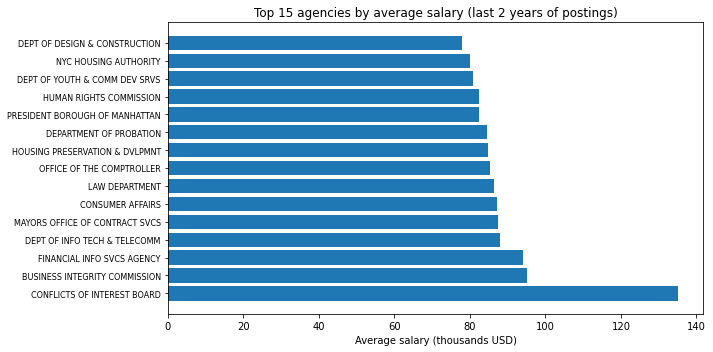

In [30]:
# Last 2 years: from max date in data minus 2 years
from datetime import timedelta
max_date = df_analytics.agg(F.max("posting_date")).collect()[0][0]
cutoff_py = (max_date - timedelta(days=730)) if max_date else None
df_last2 = df_sal.filter(F.col("posting_date").isNotNull() & (F.col("posting_date") >= F.lit(cutoff_py)))
kpi5 = df_last2.groupBy("Agency").agg(
    F.avg("salary_mid_annual").alias("avg_salary"),
    F.count("*").alias("posting_count")
).orderBy(F.desc("avg_salary")).limit(15)
kpi5.show(15, truncate=40)
kpi5_pd = kpi5.toPandas()
plt.figure(figsize=(10, 5))
plt.barh(range(len(kpi5_pd)), kpi5_pd["avg_salary"] / 1000)
plt.yticks(range(len(kpi5_pd)), kpi5_pd["Agency"], fontsize=8)
plt.xlabel("Average salary (thousands USD)")
plt.title("Top 15 agencies by average salary (last 2 years of postings)")
plt.tight_layout()
plt.show()

### KPI 6: Highest-paid skills (in this dataset)

We parse Preferred Skills (and/or Job Description) for skill-like phrases and average salary per skill. Dataset is NYC jobs; we interpret "US market" as skills with highest pay in this NYC job market.

+--------------------------------------------------+------------------+-----+
|                                             skill|        avg_salary|count|
+--------------------------------------------------+------------------+-----+
|                                        commercial|155213.66666666666|    6|
|                                    public utility|          146779.9|    5|
|                                           mongodb|          133971.0|    6|
|                                             mysql|          133971.0|    6|
|          construction and construction management|          126936.5|    5|
|             capacity to organize and analyze data|          126936.5|    5|
|track and staff multiple contracts for engineer...|          126936.5|    5|
|                                      presentation|         120875.55|   10|
|                                    other agencies|          118143.5|    6|
|                                        inspectors|          11

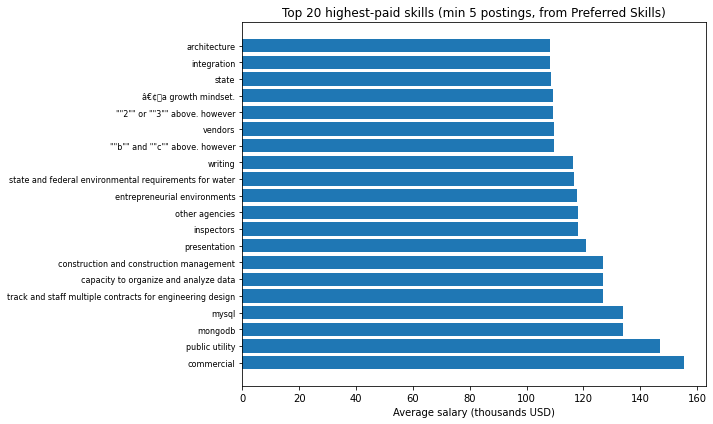

In [31]:
# Extract skills from Preferred Skills: split by common delimiters and explode
from pyspark.sql.functions import explode, split
skills_raw = df_sal.withColumn("skills", F.split(F.regexp_replace(F.lower(F.coalesce(F.col("Preferred Skills"), F.lit(""))), r"[,;•·\n]", ","), ","))
# Flatten and trim
skills_flat = skills_raw.withColumn("skill", explode("skills")) \
    .withColumn("skill", F.trim(F.col("skill"))) \
    .filter((F.length(F.col("skill")) >= 4) & (F.length(F.col("skill")) <= 80))
# Aggregate avg salary per skill (min 5 postings)
kpi6 = skills_flat.groupBy("skill").agg(
    F.avg("salary_mid_annual").alias("avg_salary"),
    F.count("*").alias("count")
).filter(F.col("count") >= 5).orderBy(F.desc("avg_salary")).limit(20)
kpi6.show(20, truncate=50)
kpi6_pd = kpi6.toPandas()
plt.figure(figsize=(10, 6))
plt.barh(range(len(kpi6_pd)), kpi6_pd["avg_salary"] / 1000)
plt.yticks(range(len(kpi6_pd)), kpi6_pd["skill"], fontsize=8)
plt.xlabel("Average salary (thousands USD)")
plt.title("Top 20 highest-paid skills (min 5 postings, from Preferred Skills)")
plt.tight_layout()
plt.show()

---
# Part 2: Data Processing

- Cleaning and column pre-processing
- At least 3 feature engineering techniques
- Feature removal based on exploration
- Store processed data to target file

In [33]:
# --- Cleaning & pre-processing functions ---

def clean_string_column(df: DataFrame, col_name: str) -> DataFrame:
    """Trim whitespace and replace empty strings with null for a string column."""
    return df.withColumn(col_name, F.when(F.trim(F.col(col_name)) == "", None).otherwise(F.trim(F.col(col_name))))

def cast_salary_columns(df: DataFrame) -> DataFrame:
    """Cast Salary Range From/To to double after removing commas."""
    return df \
        .withColumn("Salary Range From", F.regexp_replace(F.col("Salary Range From"), "[,$]", "").cast(DoubleType())) \
        .withColumn("Salary Range To", F.regexp_replace(F.col("Salary Range To"), "[,$]", "").cast(DoubleType()))

def cast_date_columns(df: DataFrame) -> DataFrame:
    """Cast date columns to DateType."""
    for c in ["Posting Date", "Post Until", "Posting Updated", "Process Date"]:
        if c in df.columns:
            df = df.withColumn(c, F.to_date(F.col(c), "yyyy-MM-dd"))
    return df

def cast_numeric_optional(df: DataFrame, col_name: str) -> DataFrame:
    """Safely cast a column to integer (non-numeric -> null)."""
    return df.withColumn(col_name, F.regexp_replace(F.col(col_name), "[^0-9]", "").cast(IntegerType()))

In [34]:
# --- Feature engineering (at least 3) ---

def add_salary_midpoint_annual(df: DataFrame) -> DataFrame:
    """FE1: Midpoint of salary range, normalized to annual (Hourly*2080, Daily*260)."""
    d = df.withColumn("_from", F.col("Salary Range From")).withColumn("_to", F.col("Salary Range To"))
    d = d.withColumn("_mid", (F.col("_from") + F.col("_to")) / 2)
    d = d.withColumn(
        "salary_mid_annual",
        F.when(F.lower(F.col("Salary Frequency")).contains("hour"), F.col("_mid") * 2080)
         .when(F.lower(F.col("Salary Frequency")).contains("day"), F.col("_mid") * 260)
         .otherwise(F.col("_mid"))
    ).drop("_from", "_to", "_mid")
    return d

def add_degree_level(df: DataFrame) -> DataFrame:
    """FE2: Derived degree level from Minimum Qual Requirements text."""
    req = F.lower(F.coalesce(F.col("Minimum Qual Requirements"), F.lit("")))
    return df.withColumn(
        "degree_level",
        F.when(req.rlike(r"ph\.?d|doctorate"), F.lit("PhD"))
         .when(req.rlike(r"master\'?s|m\.?b\.?a|graduate degree"), F.lit("Master"))
         .when(req.rlike(r"baccalaureate|bachelor|four.year college"), F.lit("Bachelor"))
         .when(req.rlike(r"associate|60 semester credits"), F.lit("Associate"))
         .when(req.rlike(r"high school|ged|equivalent"), F.lit("High school"))
         .otherwise(F.lit("Unspecified"))
    )

def add_posting_year_and_tenure(df: DataFrame) -> DataFrame:
    """FE3: Posting year and years since posting (for recency)."""
    max_d = df.agg(F.max("Posting Date")).collect()[0][0]
    return df.withColumn("posting_year", F.year(F.col("Posting Date"))) \
        .withColumn("years_since_posting", F.months_between(F.lit(max_d), F.col("Posting Date")) / 12 if max_d else F.lit(None))

def add_num_positions_clean(df: DataFrame) -> DataFrame:
    """FE4 (bonus): Clean # Of Positions as integer (new column num_positions)."""
    return df.withColumn("num_positions", F.regexp_replace(F.col("# Of Positions"), "[^0-9]", "").cast(IntegerType()))

In [42]:
# Build processed pipeline: clean -> cast -> feature engineering -> drop unused columns
# Columns to drop (based on profiling): long text for modeling, redundant, or low value
COLS_TO_DROP = [
    "Job Description", "Minimum Qual Requirements", "Preferred Skills", "Additional Information",
    "To Apply", "Recruitment Contact", "Residency Requirement", "Work Location 1", "Division/Work Unit"
]

def process_and_save(raw_df: DataFrame, output_path: str) -> DataFrame:
    """Full pipeline: clean, cast, feature engineering, feature removal, save."""
    # Clean key string columns
    for c in ["Agency", "Business Title", "Job Category", "Salary Frequency", "Posting Type"]:
        if c in raw_df.columns:
            raw_df = clean_string_column(raw_df, c)
    # Cast
    raw_df = cast_salary_columns(raw_df)
    raw_df = cast_date_columns(raw_df)
    raw_df = add_num_positions_clean(raw_df)
    # Feature engineering
    raw_df = add_salary_midpoint_annual(raw_df)
    raw_df = add_degree_level(raw_df)
    max_date = raw_df.agg(F.max("Posting Date")).collect()[0][0]
    raw_df = raw_df.withColumn("posting_year", F.year(F.col("Posting Date")))
    raw_df = raw_df.withColumn("years_since_posting", F.months_between(F.lit(max_date), F.col("Posting Date")) / 12)
    # Drop columns we don't need for downstream
    to_drop = [c for c in COLS_TO_DROP if c in raw_df.columns]
    processed = raw_df.drop(*to_drop)
    # Parquet does not allow column names with spaces or " ,;{}()\n\t=" — rename for write
    def sanitize_col(name):
        return name.replace(" ", "_").replace("/", "_").replace("#", "num_").replace(";", "_").replace(",", "_").replace("{", "_").replace("}", "_").replace("(", "_").replace(")", "_").replace("\n", "_").replace("\t", "_").replace("=", "_").strip("_")
    for old_name in processed.columns:
        new_name = sanitize_col(old_name)
        if new_name != old_name:
            processed = processed.withColumnRenamed(old_name, new_name)
    # Write (single partition for small dataset; use coalesce(1) or repartition for Parquet)
    processed.write.mode("overwrite").parquet(output_path)
    return processed

# Run and save (path valid inside Docker; use /notebook/processed or /app/processed)
OUTPUT_PATH = "/notebook/processed_nyc_jobs"
processed_df = process_and_save(df, OUTPUT_PATH)
print("Processed row count:", processed_df.count())
processed_df.printSchema()

Processed row count: 2946
root
 |-- Job_ID: string (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Posting_Type: string (nullable = true)
 |-- num__Of_Positions: string (nullable = true)
 |-- Business_Title: string (nullable = true)
 |-- Civil_Service_Title: string (nullable = true)
 |-- Title_Code_No: string (nullable = true)
 |-- Level: string (nullable = true)
 |-- Job_Category: string (nullable = true)
 |-- Full-Time_Part-Time_indicator: string (nullable = true)
 |-- Salary_Range_From: double (nullable = true)
 |-- Salary_Range_To: double (nullable = true)
 |-- Salary_Frequency: string (nullable = true)
 |-- Work_Location: string (nullable = true)
 |-- Hours_Shift: string (nullable = true)
 |-- Posting_Date: date (nullable = true)
 |-- Post_Until: date (nullable = true)
 |-- Posting_Updated: date (nullable = true)
 |-- Process_Date: date (nullable = true)
 |-- num_positions: integer (nullable = true)
 |-- salary_mid_annual: double (nullable = true)
 |-- degree_level: s

---
# Test cases

Unit tests for key functions (cleaning, feature engineering, KPI helpers).

In [ ]:
def test_get_salary_frequency(mock_data: list, expected_result: list, schema: list = ["id", "Salary Frequency"]):
    mock_df = spark.createDataFrame(data=mock_data, schema=schema)
    assert get_salary_frequency(mock_df) == expected_result

def test_clean_string_column():
    data = [("  a  ",), ("",), (None,)]
    d = spark.createDataFrame(data, ["x"])
    d2 = clean_string_column(d, "x")
    rows = d2.collect()
    assert rows[0]["x"] == "a"
    assert rows[1]["x"] is None
    assert rows[2]["x"] is None

def test_add_degree_level():
    data = [(1, "A baccalaureate degree required"), (2, "Master's degree preferred"), (3, "")]
    d = spark.createDataFrame(data, ["id", "Minimum Qual Requirements"])
    d = add_degree_level(d)
    rows = d.select("degree_level").collect()
    assert rows[0]["degree_level"] == "Bachelor"
    assert rows[1]["degree_level"] == "Master"
    assert rows[2]["degree_level"] == "Unspecified"

def test_build_analytics_df():
    data = [("1", "Ag", "1", "50000", "60000", "Annual", "2019-01-01")]
    d = spark.createDataFrame(data, ["Job ID", "Agency", "# Of Positions", "Salary Range From", "Salary Range To", "Salary Frequency", "Posting Date"])
    d = build_analytics_df(d)
    row = d.select("salary_mid_annual").first()
    assert row["salary_mid_annual"] == 55000.0

# Run tests
test_get_salary_frequency(mock_data, expected_result)
test_clean_string_column()
test_add_degree_level()
test_build_analytics_df()
print("All tests passed.")

All tests passed.
